
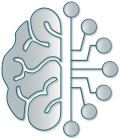

**Start at:** Monday 17 June 2024, 15:14:07  
**Hostname:** insa-20474 (Linux)

<p style="text-align: center"><img width="800px" src="./config/svg/pyPhysChemBanner.svg" style="margin-left:auto; margin-right:auto"/></p>

In [22]:
import os
import sys

cwd0 = './config/'
sys.path.append(cwd0)

import visualID_Eng as vID
from visualID_Eng import color
vID.init(cwd0)

__author__ = "Matthieu CHARNAY, LPCNO (INSA-CNRS-UT3 lab, Toulouse, France)"

# Modèle d'Ising par les portes quantiques

Nous allons ici modéliser le modèle d'Ising dans le cas 1D pseudo-infini en utilisant les portes quantiques.
La résolution exacte du modèle est permise en ce qu'il est intégrable, ce qui n'est pas un élément universel - les résolutions exactes sont souvent limitées.

Tout le processus est expliqué dans le papier : A. Cervera-Lierta, Quantum 2, 114 (2018)

### Méthode

La méthode est la même que celle utilisée pour la résolution analytique du problème.

**Idée globale** : par une suite de transformations, passer d'un hamiltonien diagonal (dont on connaît aisément l'état fondamental) à l'hamiltonien de notre système ; cela permet d'en déduire l'état de plus faible énergie du système.

**Résolution concrète** : en utilisant la réversibilité des opérateurs, l'on part en réalité de l'hamiltonien de notre modèle, que l'on cherchera à diagonaliser. On fixe ensuite les différents paramètre de sorte à le minimiser. Les différentes opérations utilisées n'auront ensuite plus qu'à être inversées.

**Etapes successives** :

- Etat initial : hamiltonien présentant les couplages entre premiers voisins.

- Etape 1 : réaliser une transformée de Jordan-Wigner pour passer d'un état de particules à spin 1/2 à un état fermionique.

- Etape 2 : réaliser une transformée de Fourier pour passer des modes fermioniques à l'espace des moments.

- Etape 3 : réaliser une transformée de Bogoliubov pour découpler les termes de moments opposés.

- Etat final : hamiltonien diagonal.

### Traduction en portes quantiques

L'étape 1 n'a aucun impact sur les coefficients des différents états de la fonction d'onde, elle n'utilise donc strictement aucune porte quantique. Cela est expliqué dans la __[fiche associée (Transformation de Jordan-Wigner)](./QCpy-additionalFiles/theoryReminderSheets(FR)/Transformation_de_Jordan-Wigner.pdf)__.

L'étape 2 se base sur la méthode présentée dans les papiers : A. J. Ferris, Phys. Rev. Lett. 113, 010401 (2014) ; V. Murg, V. E. Korepin and F. Verstraete, Phys. Rev. B 86, 045125 (2012)
Celle-ci est décrite en détail dans la __[fiche associée (Transformées de Fourier - équivalent FFT)](./QCpy-additionalFiles/theoryReminderSheets(FR)/Transformees_de_Fourier_Quantiques.pdf)__.

L'étape 3 se base sur la méthode présentée dans le papier : V. Murg, V. E. Korepin and F. Verstraete, Phys. Rev. B 86, 045125 (2012)
Elle est décrite en détail dans la __[fiche associée (Transformation de Bogoliubov)](./QCpy-additionalFiles/theoryReminderSheets(FR)/Transformation_de_Bogoliubov.pdf)__.

### Comment utiliser ce Jupyter Notebook

Nous allons ensemble apprendre les éléments fondamentaux de la programmation avec MyQLM en implémentant ces différentes étapes ainsi que tous les composants nécessaires. Les différents éléments de syntaxe pertinents à cet Jupyter Notebook apparaissent dans l'__[annexe de formation](QCpy-1(FR)appendix-Modele_d-Ising.ipynb)__, sous forme d'exemples variés et partiellement annotés. La combinaison du présent Jupyter Notebook et de son annexe permettent au lecteur autonome et néophyte l'apprentissage des bases de MyQLM.

<hr style="border:2px solid gray">

## **Partie I** : la transformée de Fourier

Réalisons maintenant le circuit de portes quantiques permettant de réaliser la Transformée de Fourier.

### **A** - Définition des portes quantiques

Afin de construire la Transformée de Fourier en un circuit compréhensible pour l'être humain, nous allons définir des portes quantiques abstraites. Composées d'un enchaînement de portes quantiques classiques, celles-ci allègent la lecture des circuit dans lesquels nous nous en servons, et permettent de résumer des sous-circuit en une boîte noire réalisant une fonction précise.

#### 1) Préambule

Avant de rentrer dans le vif du sujet, nous allons construire le circuit correspondant à l'une des portes quantiques dont nous nous servirons plus tard. Puis, par des tests successifs, nous allons en retrouver la matrice.

**Q1)**

**a)** Créer une *routine* contenant le circuit de la porte "séparatrice de faisceaux". Afficher le circuit obtenu.

**b)** À l'aide d'un processeur quantique (*qpu*) virtuel obtenir la sortie par défaut de la porte quantique.

**c)** Créer un *programme* en appliquant des portes \[X] successivement sur les différentes entrées du circuit et en réutilisant la routine définie à la question 1) a) (voir effet des portes usuelles __[ici](./QCpy-additionalFiles/available_gates.ipynb)__), retrouver par cette méthode la matrice associée à la porte quantique "séparatrice de faisceaux".

On donne le circuit de la porte :

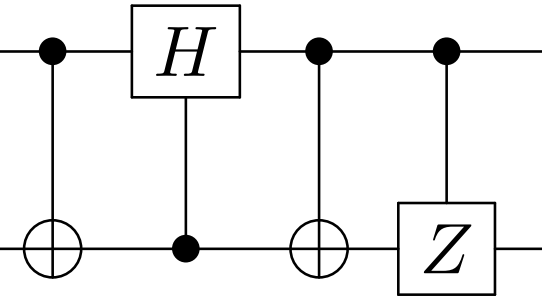

Avec, par ordre d'apparition :
- une porte CNOT
- une porte de Hadamard contrôlée
- une porte Z contrôlée

Le point noir sur le schéma indique le qubit de contrôle.

<div class="alert alert-block alert-info">
<b>Rappel :</b> Une routine est une instance indépendante d'un circuit quantique, elle a la particularité d'être faite pour être réutilisée dans d'autres circuits quantiques, en l'appelant comme une porte quantique. Elle se définit en utilisant le décorateur @qrout sur une procédure (fonction sans return) appliquant des portes quantiques. Plus de détails sont disponibles dans la documentation MyQLM.
</div>

<div class="alert alert-block alert-warning">
<b>Attention :</b> L'affichage de la porte Z contrôlée peut varier et prendre la forme de deux points noirs reliés ; il ne s'agit pas d'une erreur, la porte reste fonctionnelle. Il faut cependant faire attention à l'avoir bien définie dans le bon sens (quel qubit contrôle quel autre).
</div>

In [1]:
from qat.lang import qrout, CNOT, H, Z

#Code de la question 1) a) Créer une routine contenant le circuit de la porte "séparatrice de faisceaux". Afficher le circuit obtenu.




<div class="alert alert-block alert-info">
<b>Conseil :</b> Le résultat d'une soumission à un processeur quantique virtuel est une liste d'objets qat.core.Result ; ces derniers contiennent de multiple champs. Dans un premier temps, nous conseillons pour chaque objet dans cette liste d'utiliser la commande print("Etat %s, amplitude %s, probabilité %s"%(res.state, res.amplitude, res.probability)). Plus de détails sont disponibles dans la documentation MyQLM.
</div>

In [2]:
from qat.qpus import get_default_qpu

#Code de la question 1) b) À l'aide d'un processeur quantique (qpu) virtuel obtenir la sortie par défaut de ce circuit quantique.




<div class="alert alert-block alert-info">
<b>Conseil :</b> Un programme est une instance indépendante d'un circuit quantique, qui ne peut être incluse dans un autre. Il se définit en appelant l'initialisateur de la classe Program : Program(). Plus de détails sont disponibles dans la documentation MyQLM.

Dans le cas de cette question, veuillez définir un seul programme en mettant ou non en commentaire les commandes de la porte quantique X sur les qubits.
</div>

In [3]:
from qat.lang import Program, X

#Code et réponse pour la question 1) c) Créer un programme en appliquant des portes [X] successivement sur les différentes entrées du circuit 
#celui-ci doit réutiliser la routine définie à la question 1) a)
#retrouver par cette méthode la matrice associée à la porte quantique "séparatrice de faisceaux".






# Connaissant les composantes successives des vecteurs sur deux qubits : |00>, |01>, |10>, |11>
# Redonner ici les coefficients de la matrice :
#
# ( ? ? ? ? )
# ( ? ? ? ? )
# ( ? ? ? ? )
# ( ? ? ? ? )
#
# On rappelle : 1/sqrt(2)≈0,7071 

#### 2) Construction des portes quantiques

Nous allons maintenant pouvoir construite des "portes abstraites", c'est à dire des portes n'existant pas nativement dans les ordinateurs quantiques, mais que nous définissons par soucis de clarté des circuits que nous construisons. Nous allons implémenter les différentes portes de la transformée de Fourier, et ce de manières variées.

**Q2)**

**a)** Créer une fonction qui *retourne une routine* construisant le circuit de la porte "séparatrice de faisceaux" vu précédemment.

**b)** Créer une porte abstraite (F2) ayant cette fonction comme valeur du paramètre "circuit_generator".

**c)** Créer une fonction à deux paramètres (n,k) entiers, qui retourne la matrice de la porte "retard de phase" décrite dans __[cette fiche](./QCpy-additionalFiles/theoryReminderSheets(FR)/Transformees_de_Fourier_Quantiques.pdf)__.

**d)** Créer une porte abstraite (RP) ayant cette fonction comme valeur du paramètre "matrix_generator".

**e)** Créer une porte abstraite (fSWAP) ayant une fonction lambda comme paramètre "matrix_generator", cette fonction lambda retourne la matrice de la porte "fSWAP" décrite dans __[cette fiche](./QCpy-additionalFiles/theoryReminderSheets(FR)/Transformees_de_Fourier_Quantiques.pdf)__.

<div class="alert alert-block alert-info">
<b>Rappel :</b> Il est possible de créer un objet routine en appelant l'initialisateur de la classe QRoutine : QRoutine(), puis en allouant des qubits à celle-ci (QRoutine.new_wires(int:n)) et en leur appliquant des portes quantiques (QRoutine.apply(...)).
</div>

In [4]:
#Code de la question 2) a) Créer une fonction qui retourne une routine construisant le circuit de la porte "séparatrice de faisceaux" vu précédemment.




<div class="alert alert-block alert-info">
<b>Conseil :</b> Une porte abstraite peut être définie : sans implémentation (auquel cas les calculs par qpu seront impossibles) ; avec un circuit_generator (qui définit le circuit interne de la porte abstraite) ; avec un matrix_generator (qui décrit directement l'effet de la porte sur les qubits).
</div>

In [5]:
from qat.lang.AQASM import *

#Code de la question 2) b) Créer une porte abstraite (F2) ayant cette fonction comme valeur du paramètre "circuit_generator"




In [6]:
import numpy as np

#Code de la question 2) c) Créer une fonction à deux paramètres (n,k) entiers, qui retourne la matrice de la porte "retard de phase"




In [8]:
#Code de la question 2) d) Créer une porte abstraite (RP) ayant cette fonction comme valeur du paramètre "matrix_generator".





<div class="alert alert-block alert-info">
<b>Rappel :</b> Les fonctions lambda sont natives à Python. Il s'agit de petites fonctions anonymes pouvant prendre n'importe quel nombre d'argument, mais n'ayant qu'une unique expression en retour. La syntaxe est telle que ci-dessous :

lambda *arguments* : *expression*
</div>

In [9]:
#Code de la question 2) e) Créer une porte abstraite (fSWAP) ayant une fonction lambda comme paramètre "matrix_generator"





### **B** - Construction de la Transformée de Fourier Quantique (équivalent FFT)

Finalement, après avoir défini toutes nos portes abstraites, il ne nous reste plus qu'à les combiner pour former la Transformée de Fourier Quantique. Dans un premier temps, nous nous intéresserons au cas à 4 qubits, puis nous nous pencherons sur le cas à N qubits.

#### 1) Transformée à 4 qubits

**Q3)** À l'aide du schéma ci-dessous de la décomposition de la Transformée de Fourier à 4 qubits, et par la méthode de votre choix, utilisez les portes quantiques préalablement définies pour reproduire cette structure.

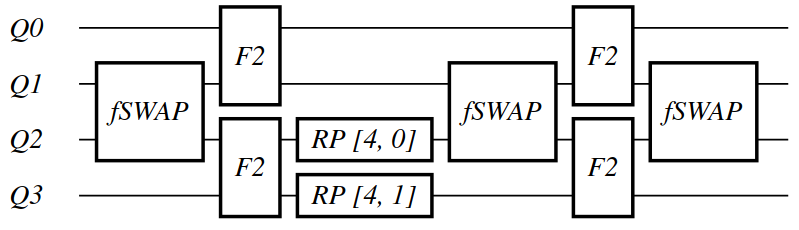

In [10]:
#Code de la question 3) utilisez les portes quantiques préalablement définies pour reproduire la Transformée de Fourier Quantique à 4 qubits







#### 2) Transformée à N qubits

Nous donnons ci-dessous le programme permettant de réaliser le circuit pour N qubits (puissance de 2), et donnons le schéma du résultat attendu pour N=16. Plusieurs sous-fonctions doivent être réalisées, ce sans quoi le programme principal ne fonctionne pas.

(ici la nom des portes "RP" a été changé en "ω" par soucis de légèreté de la lecture)

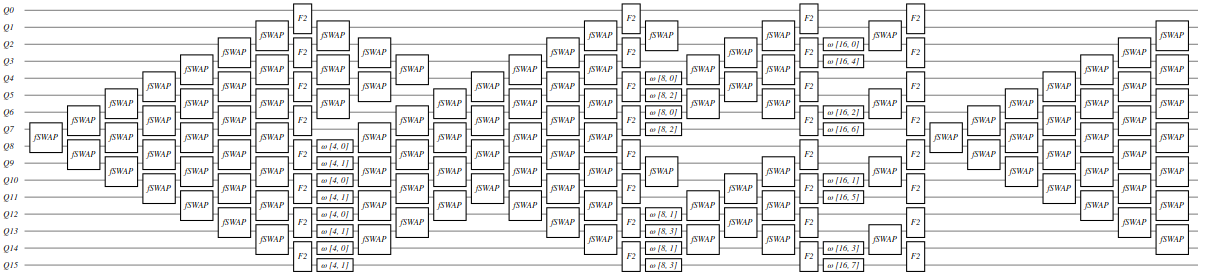

**Q4)** 

**a)** À l'aide du schéma ci-dessus, compléter la fonction "F2Build". Cette fonction construit un mur de portes F2 : du premier jusqu'au dernier qubits.

*(optionnel)* **b)** Toujours à l'aide du schéma ci-dessus, prendre successivement deux fermions (sur les qubits 7 et 8 par exemple) et trouver la suite de portes que ceux-ci subissent (rappel : une porte fSWAP va échanger la position de deux fermions)

**c)** À l'aide du schéma ci-dessus, compléter la fonction "fSwapTriangleBuild". Cette fonction construit une structure en triangle de portes fSWAP. 

**d)** Définir une porte quantique ayant la QFFT (ou "Transformée de Fourier Rapide Quantique" - nom non officiel) comme générateur de circuit.

**e)** Définir un *programme* qui utilise cette porte quantique sur 16 qubits. Afficher la programme avec un appel à la méthode Circuit.display() sans paramètres.

**f)** Ajouter le paramètre "depth" dans la méthode display. Faire varier sa valeur à partir de 0. Que permet-il ?

In [11]:
from math import log2

def QFFTfunction(n):
    qrout = QRoutine()
    qreg = qrout.new_wires(n)
    listPhaseDelay=[0]
    for i in range(1,int(log2(n))):
        fSwapWallBuild(n,i,qrout,qreg,False)
        F2Build(n,qrout,qreg)
        for k in range(2**(i-1)):
            for j in range(int((2*k+1)*n/(2**i)),int((2*k+2)*n/(2**i))):
                qrout.apply(RP(2**(i+1),listPhaseDelay[k]+(j%2)*(2**(i-1))),qreg[j])
        fSwapWallBuild(n,i,qrout,qreg,True)
        for t in range(len(listPhaseDelay)):
            listPhaseDelay=listPhaseDelay[0:2*t+1]+[listPhaseDelay[2*t]+2**(i-1)]+listPhaseDelay[2*t+1:]
    F2Build(n,qrout,qreg)
    fSwapWallBuild(n,1,qrout,qreg,False)
    return(qrout)

def fSwapWallBuild(n,step,qrout,qreg,inverse):
    for i in range(2**(step-1)):
        fSwapTriangleBuild(n/(2**(step-1)),qrout,qreg[int(i*n/(2**(step-1))):int((i+1)*n/(2**(step-1)))],inverse)

In [11]:
#fonction à compléter pour la question 4) a) ; cette fonction construit un mur de portes F2 : du premier jusqu'au dernier qubits
#voir case ci-dessous pour tester vos fonctions

def F2Build(n,qrout,qreg):
    r""" n : nombre de qubits concernés, qrout : routine dans laquelle écrire les portes, qreg : registre des qubits concernés (taille n)
    Cette fonction construit un mur de portes F2, du premier jusqu'au dernier qubits, tous subissent la porte F2 deux à deux.
    """
    



#fonction à compléter pour la question 4) c) ; cette fonction construit une structure en triangle de portes fSWAP
#voir case ci-dessous pour tester vos fonctions

def fSwapTriangleBuild(n,qrout,qreg,inverse):
    r""" n : nombre de qubits concernés, qrout : routine dans laquelle écrire les portes, qreg : registre des qubits concernés (taille n)
    Cette fonction construit un triangle de portes fSWAP : partant d'une porte entre les deux qubits centraux, puis deux portes, etc... 
    seuls le premier et le dernier qubit ne sont pas concernés par les portes fSWAP
    Le sens est inversé si le paramètre inverse vaut True : l'on finira le triangle par sa pointe
    """




In [13]:
#Vous pouvez grâce au code suivant tester le bon fonctionnement de vos fonctions

N=16 #elles doivent fonctionner pour tout N puissance de 2 (N=1 non compris)

def testQ4ac(n):
    qrout=QRoutine()
    qreg=qrout.new_wires(n)
    F2Build(n,qrout,qreg)
    #fSwapTriangleBuild(n,qrout,qreg,False)
    #fSwapTriangleBuild(n,qrout,qreg,True)
    return(qrout)

prog=Program()
qreg=prog.qalloc(N)
testQ4ac(N)(qreg)
prog.to_circ().display()

In [12]:
#Code de la question 4) d) définir une porte quantique ayant la QFFT comme générateur de circuit





In [13]:
#Code de la question 4) e) Définir un programme qui utilise cette porte quantique sur 16 qubits, appeler la méthode Circuit.display() sans paramètres





#Code de la question 4) f) ajouter le paramètre "depth" dans la méthode display. Faire varier sa valeur à partir de 0. Que permet-il ?





<hr style="border:2px solid gray">

## **Partie II** : la transformation de Bogoliubov

Nous allons maintenant pouvoir nous pencher sur la __[transformation de Bogoliubov](./QCpy-additionalFiles/theoryReminderSheets(FR)/Transformation_de_Bogoliubov.pdf)__. Cette partie est un exercice récapitulatif, et est donc moins guidée.

**Votre mission** : à l'aide des éléments donnés ci-dessous, faites le travail nécessaire pour intégrer la Transformation de Bogoliubov au circuit de diagonalisation de l'hamiltonien pour N qubits (N puissance de 2).

**Éléments nécessaires** :
- La transformation de Bogoliubov est implémentée par des portes à 2 qubits.
- La matrice de ces portes est la suivante :
$$\begin{bmatrix} cos(\frac{θ_k}{2}) & 0 & 0 & isin(\frac{θ_k}{2}) \\ 0&1&0&0 \\ 0&0&1&0 \\  isin(\frac{θ_k}{2}) & 0 & 0 & cos(\frac{θ_k}{2})\end{bmatrix}$$
avec : $$θ_k=\arccos\left(\frac{λ-\cos\left(\frac{2πk}{n}\right)}{\sqrt{\left(λ-\cos\left(\frac{2πk}{n}\right)\right)^2+\sin^2\left(\frac{2πk}{n}\right)}}\right)$$
λ : paramètre du modèle physique correspondant à l'intensité du champ transverse, variable.
- Les portes à 2 qubits forment un mur allant du premier au dernier qubit, n correspond au nombre de qubits, k à l'index de la porte (la 3ème porte prendra k=2).
- La transformation est implémentée après la Transformée de Fourier.

In [14]:
champTransverse=0.9
N=16

#Code de la partie II











<hr style="border:2px solid gray">

## **Partie III** : finitions & exploitation du circuit quantique

Nous avons maintenant le circuit quantique permettant de passer de l'hamiltonien de notre modèle physique à un hamiltonien diagonal. Il ne nous reste plus alors qu'à :
- trouver l'état qui minimise l'hamiltonien diagonal ; préparer le système dans cet état
- y appliquer la transformation inversée
- exploiter les résultats obtenus

Pour ce premier point, les résolutions analytiques nous donne :
$$\newcommand{\ket}[1]{\left|{#1}\right\rangle}
\newcommand{\bra}[1]{\left\langle{#1}\right|}
\ket{\psi}_{H_{min}}=\left\{
    \begin{array}{ll}
        \ket{00...00} & \mbox{si λ>1}\\
        \ket{00...01} & \mbox{si λ<1}
    \end{array}
\right.$$

**Q1)** Définir le circuit quantique permettant la résolution du problème en fonction de la valeur du paramètre champTransverse.
On rappelle l'inverse d'un produit d'opérateurs : $$(\hat{A}\hat{B})^\dagger = \hat{B}^\dagger\hat{A}^\dagger$$

**Q2)** Afficher les différents états obtenus en sortie pour :
- un nombre pseudo-infini de mesures ;
- 1000 mesures.

**Q3)** 

**a)** Définir un observable "magnétisation" correspondant à la moyenne pondérée des valeurs de spin suivant Z de tous les qubits.

**b)** Calculer la valeur moyenne de cette observable sur :
- un nombre pseudo-infini de mesures ;
- 100 mesures.

**Pour conclure** : faites varier la valeur du champ transverse et le nombre de qubits, et observez les résultats obtenus.

<div class="alert alert-block alert-info">
<b>Conseil :</b> Pour cette première question, vous aurez besoin de la porte quantique X et de la méthode dag() des portes.
</div>

In [17]:
champTransverse=0.9
N=8

#Code de la question 1) Définir le circuit quantique permettant la résolution du problème en fonction de la valeur du paramètre champTransverse, l'afficher





In [18]:
#Code de la question 2) Afficher les différents états obtenus en sortie pour un nombre pseudo-infini et 1000 mesures






<div class="alert alert-block alert-warning">
<b>Attention :</b> Sur l'exploitation de ces résultats, rappelez vous la sphère de Bloch : une valeur 0 correspond à un spin up (σz=1), et une valeur 1 correspond à un spin down (σz=-1).
</div>
<div class="alert alert-block alert-info">
<b>Conseil :</b> Un observable est un objet de la classe Observable ; un terme peut y être ajouté par sa méthode add_term(). Un terme est un objet de la classe Term(). Plus de détails sont disponibles dans la documentation MyQLM.
</div>

In [19]:
from qat.core import Observable, Term

#Code de la question 3) Définir un observable "magnétisation" correspondant à la moyenne pondérée des valeurs de spin suivant Z de tous les qubits





<div class="alert alert-block alert-info">
<b>Rappel :</b> Il est possible de soumettre des jobs qui contiennent un circuit quantique et un observable à échantillonner sur les états quantiques de sortie.

my_job = circuit.to_job(observable=my_obs)

Dans certains cas, il peut arriver qu'un QPU ne supporte pas nativement l'évaluation des observables. Le plugin ObservableSplitter est là pour combler cette lacune et permettre à tout QPU, y compris ceux limités aux échantillonages, d'être capable d'évaluer des observables. 

Il s'appelle donc en combinaison à un qpu classique : qpu = ObservableSplitter() | get_default_qpu()
</div>

In [20]:
from qat.plugins import ObservableSplitter

#Code de la question 4) Calculer la valeur moyenne de cette observable sur un nombre pseudo-infini et 100 mesures






<div class="alert alert-block alert-success">
<b>Félicitations :</b> Vous avez terminé ce Jupyter Notebook introductif à la programmation en MyQLM pour l'informatique quantique.
</div>


Si vous souhaitez vérifier votre travail, ou obtenir des éclaircissements, un document de correction est disponible __[ici](QCpy-1(FR)correction-Modele_d-Ising.ipynb)__.